## HeavyWater Classification Test
 This program contains Three main parts:
 1. Data preprocessing
 2. Classifiers training
 3. Results comparison

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import re, sys, os, csv, time
# plotting
import matplotlib.pyplot as plt
import seaborn as sn
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel,f_classif,SelectKBest
# feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score,roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
## test ensemble methods
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier,VotingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

### Data Preprocessing
1. Read and add metadata, Delete null and duplicated rows
2. Check if the classes are balanced by counting the number of document for each category
3. Label Encoding

In [2]:
## Step 1
# read data from csv file
dataset = pd.read_csv('data/shuffled-full-set-hashed.csv',header=None,sep=',')
dataset.columns=['Labels','Values']
print "Original Dataset Shape:                  ", dataset.shape
# drop rows that contain null values and duplicated
dataset=pd.DataFrame(dataset)
dataset=dataset[pd.notnull(dataset)]
print "Dataset (without null rows) Shape:       ", dataset.shape
dataset=dataset.drop_duplicates()
print "Dataset (without duplicated rows) Shape: ", dataset.shape
dataset.info()

Original Dataset Shape:                   (62204, 2)
Dataset (without null rows) Shape:        (62204, 2)
Dataset (without duplicated rows) Shape:  (60548, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 60548 entries, 0 to 62203
Data columns (total 2 columns):
Labels    60548 non-null object
Values    60542 non-null object
dtypes: object(2)
memory usage: 1.4+ MB


                     Labels  Values
0                      BILL   18449
1             POLICY CHANGE   10229
2       CANCELLATION NOTICE    9571
3                    BINDER    8590
4      DELETION OF INTEREST    4779
5      REINSTATEMENT NOTICE    4295
6               DECLARATION     966
7        CHANGE ENDORSEMENT     866
8            RETURNED CHECK     730
9         EXPIRATION NOTICE     719
10       NON-RENEWAL NOTICE     618
11              BILL BINDER     277
12  INTENT TO CANCEL NOTICE     227
13              APPLICATION     226


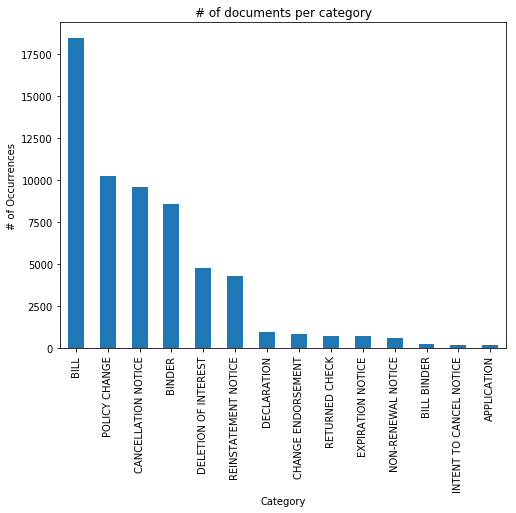

In [3]:
## Step 2
# Check if the classes are balanced by counting the number of document for each category
sorted_counts=dataset.groupby('Labels').Values.count().sort_values(ascending=False)
summary=pd.DataFrame(sorted_counts).reset_index()
print summary
fig=plt.figure(figsize=(8,6))
sorted_counts.plot.bar(ylim=0)
plt.title('# of documents per category')
plt.ylabel('# of Occurrences')
plt.xlabel('Category')
plt.show()

### Data Summary
There are 62204 samples in the dataset, and each sample have two component: Document label and Word Values.

### Data Preprocessing
Check the number of document for each category (document labels) to see if the classes are balanced or imbalanced.
From the figure, we can see that there are 14 categories, and "BILL","Policy change", "Binder", and "cancellation Notice" have more samples.

In [4]:
## Step 3 Label Encoding
encoder=LabelEncoder()
encoder.fit(dataset['Labels'])
pickle.dump(encoder, open('labelEncoder.pkl','wb')) # save model using Pickle
dataset['ID']=encoder.transform(dataset['Labels'])
print "Label enCoding: ", range(14)
print "Label Decoding: ", encoder.inverse_transform(range(14))

Label enCoding:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Label Decoding:  ['APPLICATION' 'BILL' 'BILL BINDER' 'BINDER' 'CANCELLATION NOTICE'
 'CHANGE ENDORSEMENT' 'DECLARATION' 'DELETION OF INTEREST'
 'EXPIRATION NOTICE' 'INTENT TO CANCEL NOTICE' 'NON-RENEWAL NOTICE'
 'POLICY CHANGE' 'REINSTATEMENT NOTICE' 'RETURNED CHECK']


## Feature Selection

Goals: Small Size (file size), Computational time (Traning especially testing), and accuracy

### Addressing overfitting:

1. reduce the number of features (manually or select from model)

2. Regularization (keep all the features, decrease the maganitude/values of parameters)


In [32]:
# get X : words; Y: Labels/Classes
#Y=dataset['ID']
#X=[str(i) for i in dataset['Values']]
# create training (90%) and test sets (10%)
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
## feature extraction on training set
#tfidf = TfidfVectorizer(sublinear_tf=True, min_df=3, norm='l2', encoding='utf-8', ngram_range=(1, 2)) # 2 Grams
#features = tfidf.fit_transform(X_train, Y_train)
print 'Extracted features (min_df=3,ngram_range=(1, 2)):',features.shape[1]
#tfidf_10 = TfidfVectorizer(sublinear_tf=True, min_df=10, norm='l2', encoding='utf-8', ngram_range=(1, 2)) # 2 Grams
#features_10 = tfidf_10.fit_transform(X_train, Y_train)
print 'Extracted features (min_df=10,ngram_range=(1, 2)):',features_10.shape[1]
#tfidf_N3 = TfidfVectorizer(sublinear_tf=True, min_df=10, norm='l2', encoding='utf-8', ngram_range=(1, 3)) # 2 Grams
#features_N3 = tfidf_N3.fit_transform(X_train, Y_train)
print 'Extracted features (min_df=10,ngram_range=(1, 3)):',features_N3.shape[1]
#tfidf_N5 = TfidfVectorizer(sublinear_tf=True, min_df=10, norm='l2', encoding='utf-8', ngram_range=(1, 5)) # 2 Grams
#features_N5 = tfidf_N5.fit_transform(X_train, Y_train)
print 'Extracted features (min_df=10,ngram_range=(1, 5)):',features_N5.shape[1]
#tfidf_N3_20 = TfidfVectorizer(sublinear_tf=True, min_df=20, norm='l2', encoding='utf-8', ngram_range=(1, 3)) # 2 Grams
#features_N3_20 = tfidf_N3_20.fit_transform(X_train, Y_train)
print 'Extracted features (min_df=20,ngram_range=(1, 3)):',features_N3_20.shape[1]
tfidf_N3_5_max = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95,norm='l2', encoding='utf-8', ngram_range=(1, 3)) # 2 Grams
features_N3_5_max = tfidf_N3_5_max.fit_transform(X_train, Y_train)
print 'Extracted features (min_df=5,max_df=0.95,ngram_range=(1, 3)):',features_N3_5_max.shape[1]

Extracted features (min_df=3,ngram_range=(1, 2)): 814258
Extracted features (min_df=10,ngram_range=(1, 2)): 229546
Extracted features (min_df=10,ngram_range=(1, 3)): 336138
Extracted features (min_df=10,ngram_range=(1, 5)): 446320
Extracted features (min_df=20,ngram_range=(1, 3)): 157843
Extracted features (min_df=5,max_df=0.95,ngram_range=(1, 3)): 739988


#### Data Analysis

The number of extracted features with min_df=3 and 2 Ngram is 814,258, and this number is too large for efficient classification analysis. 

The following steps can be used to reduce the number of features without affecting the accuracy.

1. Use gridsearchCV to select the smallest K value for a classifier (such as Logistic regression which has good performance on text classification)

2. select the best K features using different methods (manually and select from model), and then compare the accuracy.

In [13]:
# use gridsearchCV to select the smallest K value for Logistic Regression
cvt=CountVectorizer(min_df=3,ngram_range=(1, 2))
tft=TfidfTransformer(sublinear_tf=True)
clf=LogisticRegression(solver='sag',class_weight='balanced',max_iter=100)
pipe=Pipeline([('vect', cvt),('tfidf', tft),('clf',clf)])
parameters={'vect__max_features':[100000,400000,800000]}
grid_LR_large=GridSearchCV(pipe,cv=3,param_grid=parameters)
grid_LR_large.fit(X,Y)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        st... penalty='l2', random_state=None,
          solver='sag', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'vect__max_features': [100000, 400000, 800000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [14]:
results_large=grid_LR_large.cv_results_
pd.DataFrame(results_large).head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_vect__max_features,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,212.030667,12.162333,0.752527,0.802884,100000,{u'vect__max_features': 100000},3,0.786694,0.840167,0.704752,0.753177,0.766131,0.815308,3.194034,0.386301,0.034810,0.036584
1,352.891333,13.085667,0.799135,0.861499,400000,{u'vect__max_features': 400000},2,0.810472,0.873269,0.801467,0.867806,0.785459,0.843423,4.028733,0.062404,0.010344,0.012975
2,467.646667,14.542333,0.800638,0.864577,800000,{u'vect__max_features': 800000},1,0.801159,0.865117,0.773175,0.837954,0.827584,0.890661,3.236461,0.663470,0.022214,0.021521


In [6]:
# use gridsearchCV to select the smallest K value for Logistic Regression
cvt=CountVectorizer(min_df=3,ngram_range=(1, 2))
tft=TfidfTransformer(sublinear_tf=True)
clf=LogisticRegression(solver='sag',class_weight='balanced',max_iter=100)
pipe=Pipeline([('vect', cvt),('tfidf', tft),('clf',clf)])
parameters={'vect__max_features':[3000,5000,10000,30000,60000]}
grid_LR=GridSearchCV(pipe,cv=10,param_grid=parameters)
grid_LR.fit(X,Y)

D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        st... penalty='l2', random_state=None,
          solver='sag', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'vect__max_features': [3000, 5000, 10000, 30000, 60000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [12]:
results=grid_LR.cv_results_
pd.DataFrame(results).head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_vect__max_features,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,150.7997,3.3095,0.657891,0.673297,3000,{u'vect__max_features': 3000},5,0.711504,0.725816,0.601519,...,0.699719,0.707580,0.598347,0.622390,0.626819,0.632367,2.649242,0.134632,0.064393,0.064448
1,164.8713,3.3973,0.704548,0.725786,5000,{u'vect__max_features': 5000},4,0.742697,0.767201,0.746946,...,0.612957,0.638219,0.749256,0.772304,0.732970,0.752239,4.100098,0.176731,0.045176,0.044663
2,187.6856,3.4157,0.714309,0.736656,10000,{u'vect__max_features': 10000},3,0.600264,0.612234,0.723671,...,0.735250,0.753693,0.777355,0.812177,0.689980,0.710495,10.693381,0.177493,0.046356,0.051367
3,229.3037,3.4214,0.755483,0.788047,30000,{u'vect__max_features': 30000},2,0.779997,0.822753,0.787554,...,0.778218,0.808907,0.714380,0.744376,0.787698,0.818312,6.922355,0.069675,0.031607,0.034749
4,256.1694,3.4587,0.779580,0.820787,60000,{u'vect__max_features': 60000},1,0.807394,0.853585,0.775834,...,0.763014,0.800796,0.726281,0.775937,0.804067,0.841174,5.301719,0.096844,0.023436,0.022716


For extracted 814,258 features (min_df=3,ngram_range=(1, 2)),

If K (the number of selected feature) is between 30000 to 60000, the accuracy is between 75% to 78% for logistic regression method

In [25]:
# use gridsearchCV to select the smallest K value for Logistic Regression
cvt=CountVectorizer(min_df=10,ngram_range=(1, 3))
tft=TfidfTransformer(sublinear_tf=True)
clf=LogisticRegression(solver='sag',class_weight='balanced',max_iter=100)
pipe=Pipeline([('vect', cvt),('tfidf', tft),('clf',clf)])
parameters={'vect__max_features':[5000,10000,30000,60000]}
grid_LR=GridSearchCV(pipe,cv=5,param_grid=parameters)
grid_LR.fit(X,Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=10,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        s... penalty='l2', random_state=None,
          solver='sag', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'vect__max_features': [5000, 10000, 30000, 60000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [26]:
results=grid_LR.cv_results_
pd.DataFrame(results).head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_vect__max_features,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,371.4022,13.8730,0.648130,0.667418,5000,{u'vect__max_features': 5000},4,0.720535,0.734556,0.604524,...,0.608110,0.631007,0.643099,0.662270,0.664354,0.686415,16.120513,0.638906,0.042513,0.040516
1,414.9068,14.9528,0.729900,0.757333,10000,{u'vect__max_features': 10000},3,0.757841,0.785968,0.692949,...,0.718038,0.745458,0.746923,0.769121,0.733746,0.759243,9.473063,1.425052,0.022768,0.020155
2,468.3142,15.1156,0.760719,0.799008,30000,{u'vect__max_features': 30000},2,0.793249,0.831062,0.755862,...,0.730096,0.772399,0.772280,0.814042,0.752086,0.787668,8.539532,1.176141,0.021110,0.020850
3,524.3746,15.4118,0.780422,0.824454,60000,{u'vect__max_features': 60000},1,0.804969,0.849149,0.759247,...,0.755368,0.798761,0.801933,0.845482,0.780587,0.827199,7.621785,0.953934,0.020696,0.021159


In [28]:
# train and test model on logistic regression
clf=LogisticRegression()
pipe_0=Pipeline([('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=3, norm='l2', encoding='utf-8', ngram_range=(1, 3))),('clf',clf)])
pipe_0.fit(X_train, Y_train)
Y_pred_0=pipe_0.predict(X_test)
print "F1 score based on original features (814,258):      ",f1_score(Y_test,Y_pred_0,average='micro')
## features selection
# based on 1. self define; 2. selectKBest(chi2); 3. select from model
k=30000
cvt=CountVectorizer(min_df=3,ngram_range=(1, 2),max_features=k)
tft=TfidfTransformer(sublinear_tf=True)
clf=LogisticRegression()
pipe_1=Pipeline([('vect', cvt),('tfidf', tft),('clf',clf)])
pipe_1.fit(X_train, Y_train)
Y_pred_1=pipe_1.predict(X_test)
print "F1 score based on selected K top term frequency features (k=30000):  ",f1_score(Y_test,Y_pred_1,average='micro')
clf=LogisticRegression()
pipe_2=Pipeline([('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=3, norm='l2', encoding='utf-8', ngram_range=(1, 2))),('selection',SelectKBest(f_classif,k=k)),('clf',clf)])
pipe_2.fit(X_train, Y_train)
Y_pred_2=pipe_2.predict(X_test)
print "F1 score based on selected K features (SelectKBest(f_classif)): ",f1_score(Y_test,Y_pred_2,average='micro')
clf=LogisticRegression()
pipe_3=Pipeline([('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=3, norm='l2', encoding='utf-8', ngram_range=(1, 2))),('sfm',SelectFromModel(clf)),('clf',clf)])
pipe_3.fit(X_train, Y_train)
Y_pred_3=pipe_3.predict(X_test)
print "F1 score based on selected K features (SelectFromModel):   ",f1_score(Y_test,Y_pred_3,average='micro')

F1 score based on original features (814,258):       0.849545829893
F1 score based on selected K top term frequency features (k=30000):   0.864905037159
F1 score based on selected K features (SelectKBest(f_classif)):  0.844095788604
F1 score based on selected K features (SelectFromModel):    0.853014037985
